In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
random_state = 42

import python_code.Scripts as sc
import python_code.Reference as ref
import pickle

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score
from treeinterpreter import treeinterpreter as ti
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv("./data/final.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FSASSET   3904 non-null   float64
 1   FSSLTDE2  3904 non-null   float64
 2   RAWERND   3904 non-null   float64
 3   SHELDED   3904 non-null   float64
 4   FSNONCIT  3904 non-null   float64
 5   CERTHHSZ  3904 non-null   float64
 6   WRK_POOR  3904 non-null   float64
 7   FSERNDED  3904 non-null   float64
 8   FSNETINC  3904 non-null   float64
 9   FSERNDE2  3904 non-null   float64
 10  FSUSIZE   3904 non-null   float64
 11  FSSSI     3904 non-null   float64
 12  TANF_IND  3904 non-null   float64
 13  REALPROP  3904 non-null   float64
 14  LIQRESOR  3904 non-null   float64
 15  FSWAGES   3904 non-null   float64
 16  FSCSEXP   3904 non-null   float64
 17  FSSTDDE2  3904 non-null   float64
 18  FSDIS     3904 non-null   float64
 19  FSSLTDED  3904 non-null   float64
 20  TPOV      3904 non-null   floa

In [4]:
X = df.drop(columns = ['CAT_ELIG'])
y = df['CAT_ELIG']

In [5]:
#baseline, NULL Model
y.value_counts(normalize=True)

CAT_ELIG
1.0    0.625512
2.0    0.374488
Name: proportion, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=random_state)

In [7]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
np.savetxt('./data/TrainTest/X_train.csv',X_train,delimiter=',')
np.savetxt('./data/TrainTest/y_train.csv',y_train,delimiter=',')
np.savetxt('./data/TrainTest/X_test.csv',X_test,delimiter=',')
np.savetxt('./data/TrainTest/y_test.csv',y_test,delimiter=',')

In [9]:
pca = PCA(n_components=10,random_state=42)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [10]:
models = {
    'LogReg': LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boost':GradientBoostingClassifier(),
    'Ada Boost':AdaBoostClassifier(),
    'SVC':SVC(),
    'Naive Bayes':GaussianNB()}

In [12]:
#adapted from Dan Brown lecture
final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        final = pd.concat([final, pd.DataFrame([results])], ignore_index=True)
        idx+=1

C:\Users\Daniel\AppData\Local\Temp\ipykernel_6248\3752060610.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, pd.DataFrame([results])], ignore_index=True)


In [13]:
# Version 1 known good but not correct
# Build one row per model, then make the DataFrame once
#cv4 = StratifiedKFold(n_splits=4, shuffle=False)

#final = pd.DataFrame(columns=['name','cross_val_train','cross_val_test','test_recall','test_precision'])
#idx=0
#while idx < len(models.keys()):
#    for name, model in models.items():
#        results = {}
    
#        results['name'] = name
#        model.fit(X_train, y_train)
    
#        y_pred_test = model.predict(X_test)
    
#        results['cross_val_train'] = np.mean(cross_val_score(model, X_train, y_train, cv=cv4))
#        results['cross_val_test']  = np.mean(cross_val_score(model,  X_test,  y_test,  cv=cv4))
#        results['test_recall']     = recall_score(y_test, y_pred_test)        # add average='macro' if multiclass
#        results['test_precision']  = precision_score(y_test, y_pred_test)     # add average='macro' if multiclass
    
        # modern replacement for .append:
#        final.loc[len(final)] = results
#        idx+=1

In [14]:
final = final.set_index('name')
final

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.799780,0.774744,0.882920,0.784578
Decision Tree,0.860908,0.873720,0.896694,0.904167
Random Forest,0.892020,0.907850,0.920110,0.917582
Gradient Boost,0.887262,0.895904,0.921488,0.920220
Ada Boost,0.848463,0.827645,0.904959,0.858824
SVC,0.812592,0.768771,0.928375,0.799526
Naive Bayes,0.678258,0.655290,0.803030,0.741730


In [15]:
#Version 1 known good but incorrect
#pc_final = pd.DataFrame(columns=['name','cross_val_train','cross_val_test','test_recall','test_precision'])
#idx=0
#while idx < len(models.keys()):
#    for name, model in models.items():
#        results = {}
    
#        results['name'] = name
#        model.fit(X_train_pc, y_train)
    
#        y_pred_test = model.predict(X_test_pc)
    
#        results['cross_val_train'] = np.mean(cross_val_score(model, X_train_pc, y_train, cv=cv4))
#        results['cross_val_test']  = np.mean(cross_val_score(model,  X_test_pc,  y_test,  cv=cv4))
#        results['test_recall']     = recall_score(y_test, y_pred_test)        # add average='macro' if multiclass
#        results['test_precision']  = precision_score(y_test, y_pred_test)     # add average='macro' if multiclass
    
        # replacement for .append:
#        pc_final.loc[len(pc_final)] = results
#        idx+=1

In [16]:
pc_final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train_pc, y_train)
        y_pred_train = model.predict(X_train_pc)
        y_pred_test = model.predict(X_test_pc)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        pc_final = pd.concat([pc_final, pd.DataFrame([results])], ignore_index=True)
        idx+=1

C:\Users\Daniel\AppData\Local\Temp\ipykernel_6248\2782522977.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pc_final = pd.concat([pc_final, pd.DataFrame([results])], ignore_index=True)


In [17]:
pc_final = pc_final.set_index('name')
pc_final

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.730966,0.721843,0.895317,0.723026
Decision Tree,0.752196,0.741468,0.816804,0.797043
Random Forest,0.807101,0.773038,0.885675,0.814956
Gradient Boost,0.794656,0.797782,0.870523,0.793970
Ada Boost,0.768668,0.761092,0.852617,0.777638
SVC,0.745242,0.742321,0.918733,0.737832
Naive Bayes,0.690337,0.676621,0.926997,0.674349


In [43]:
for name,model in models.items():
    name = model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred_test))
    print('\n')

LogisticRegression()
              precision    recall  f1-score   support

         1.0       0.78      0.88      0.83       726
         2.0       0.76      0.61      0.67       446

    accuracy                           0.78      1172
   macro avg       0.77      0.74      0.75      1172
weighted avg       0.78      0.78      0.77      1172



DecisionTreeClassifier()
              precision    recall  f1-score   support

         1.0       0.90      0.89      0.90       726
         2.0       0.83      0.85      0.84       446

    accuracy                           0.87      1172
   macro avg       0.87      0.87      0.87      1172
weighted avg       0.88      0.87      0.87      1172



RandomForestClassifier()
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.92       726
         2.0       0.88      0.87      0.88       446

    accuracy                           0.91      1172
   macro avg       0.90      0.90      0.90      1172

In [21]:
rf = RandomForestClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'sqrt'],
       'n_estimators':[75,100,125]}
rf_gs = GridSearchCV(rf,param_grid=params)
rf_gs.fit(X_train,y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.9066623808854157


{'max_depth': None, 'max_features': None, 'n_estimators': 75}

In [22]:
#version 1 incorrect but known good
#rf = RandomForestClassifier(random_state=42)

#params = {
#    'max_depth': [None, 3, 4],
#    'max_features': [None, 'sqrt', 'log2', 0.5],
#    'n_estimators': [75, 100, 125]
#}

#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#rf_gs = GridSearchCV(
#    rf,
#    param_grid=params,
#    cv=cv,
#    scoring='accuracy',   # or your metric
#    n_jobs=-1,
#    error_score='raise'   # helpful while debugging
#)

#rf_gs.fit(X_train, y_train)
#print(rf_gs.best_params_)
#print(rf_gs.best_score_)

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [24]:
instances = X_test[[735]]
instances

array([[-0.24309398, -0.87253073, -0.59885312,  1.00652396,  1.78070948,
         1.02614408, -0.76825854, -0.59758589, -0.8826584 , -0.56404251,
         1.02614408, -0.42833737, -0.36488324, -0.03517855, -0.24501332,
        -0.55893964, -0.11792301, -1.59315573, -0.51403261,  1.0459183 ,
        -1.49056789,  0.86481274,  0.39411313, -0.12096324, -0.91848291,
        -0.1335093 , -0.59800159, -0.34230342, -0.88061189, -0.40909055,
        -0.02833014, -0.42334304]])

In [25]:
ft_list = []
prediction, bias, contributions = ti.predict(rf, instances)
print( "Prediction", prediction)
print( "Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             X.columns):
    ft_list.append((feature, np.round(c, 2)))
    print (feature, c)
    
labels, values = zip(*ft_list)

Prediction [[0.32 0.68]]
Bias (trainset prior) [[0.62901537 0.37098463]]
Feature contributions:
FSASSET [ 0.03589845 -0.03589845]
FSSLTDE2 [ 0.01527681 -0.01527681]
RAWERND [ 0.01109422 -0.01109422]
SHELDED [-0.21565273  0.21565273]
FSNONCIT [-0.01166966  0.01166966]
CERTHHSZ [ 0.02484559 -0.02484559]
WRK_POOR [ 0.00840727 -0.00840727]
FSERNDED [ 0.01110473 -0.01110473]
FSNETINC [ 0.00583512 -0.00583512]
FSERNDE2 [ 0.0100034 -0.0100034]
FSUSIZE [ 0.03959246 -0.03959246]
FSSSI [-0.02492445  0.02492445]
TANF_IND [-0.0241322  0.0241322]
REALPROP [0. 0.]
LIQRESOR [ 0.02913753 -0.02913753]
FSWAGES [ 0.00634218 -0.00634218]
FSCSEXP [ 0.00030571 -0.00030571]
FSSTDDE2 [-0.05982286  0.05982286]
FSDIS [ 0.00184838 -0.00184838]
FSSLTDED [-0.17974596  0.17974596]
TPOV [ 0.00628361 -0.00628361]
FSNK0T4 [-0.0068007  0.0068007]
FSTOTDED [ 0.01719097 -0.01719097]
FSOTHUN [ 0.00083846 -0.00083846]
FSUNEARN [-0.02806591  0.02806591]
FSGA [-0.00536623  0.00536623]
FSEARN [ 0.01822824 -0.01822824]
FSTANF 

In [26]:
df1 = pd.DataFrame(ft_list,columns=['feature','array'])
df2 = pd.DataFrame(df1["array"].to_list(), columns=['pred_0', 'pred_1'])
coef_df = pd.concat([df1,df2],axis=1).drop(columns=['array'])
coef_df.to_csv('./data/2018_indicators/coef.csv',index=None)

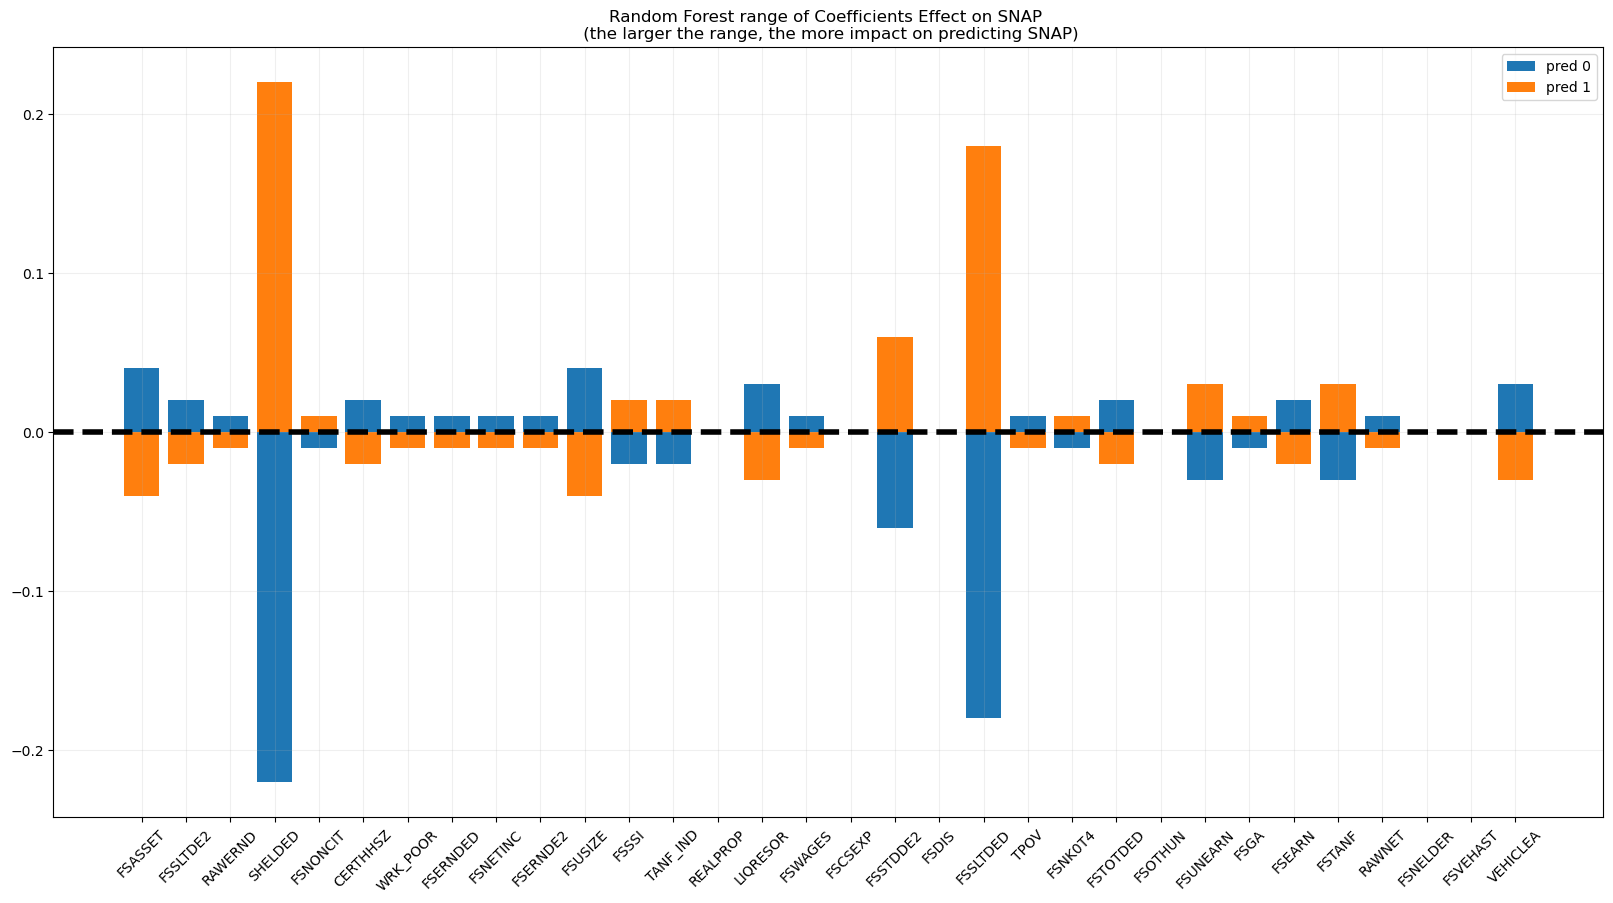

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Random Forest range of Coefficients Effect on SNAP \n (the larger the range, the more impact on predicting SNAP)')
plt.grid(zorder=0,alpha = 0.2)
xs = np.arange(len(labels))
ax.bar(xs,coef_df['pred_0'], label = 'pred 0')
ax.bar(xs,coef_df['pred_1'],label = 'pred 1')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.set_xticks(coef_df.index)
ax.set_xticklabels(coef_df['feature'],rotation = 45)
plt.legend()
plt.savefig('./images/rf_corr.png');

In [29]:
et = ExtraTreeClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'sqrt'],
       'max_leaf_nodes':[5,10]}
et_gs = GridSearchCV(et,param_grid=params)
et_gs.fit(X_train,y_train)
print(et_gs.best_score_)
et_gs.best_params_

0.7456127662709016


{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10}

In [30]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)
print(f'cross_val_train = {np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))}')
print(f'cross_val_test = {np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))}')
print(f'test_recall = {recall_score(y_test, y_pred_test)}')
print(f'test_precision = {precision_score(y_test, y_pred_test)}')

cross_val_train = 0.6903367496339678
cross_val_test = 0.6766211604095563
test_recall = 0.931129476584022
test_precision = 0.9147496617050067


In [31]:
vote = VotingClassifier([
    ('rf',RandomForestClassifier(bootstrap=False,n_estimators=1000)),
    ('gb',GradientBoostingClassifier(max_depth=10,subsample=0.8)),
    ('bag',BaggingClassifier(n_estimators = 10))
])

In [32]:
vote.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     n_estimators=1000)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=10,
                                                         subsample=0.8)),
                             ('bag', BaggingClassifier())])

In [33]:
filename = 'final_model.sav'
pickle.dump(vote, open(filename, 'wb'))